In [3]:
import numpy as np
import keras
import pandas as pd

np.random.seed(2)

data = pd.read_csv('creditcard.csv')


Using TensorFlow backend.


In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount'], axis = 1)


In [6]:
data = data.drop(['Time'], axis = 1) # we will not use Time for our model

In [7]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [8]:
# Create train/test data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [9]:
X_train.shape

(199364, 29)

In [10]:
X_test.shape

(85443, 29)

# Decision Trees

In [11]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

In [12]:
decision_tree.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
y_pred = decision_tree.predict(X_test)

In [14]:
decision_tree.score(X_test,y_test)

0.9992977774656788

In [15]:
#Plotting the confusion matrix (code can be reused)
import matplotlib.pyplot as plt
import itertools
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
y_pred = decision_tree.predict(X)
y_expected = pd.DataFrame(y)


Confusion matrix, without normalization
[[284292     23]
 [    37    455]]


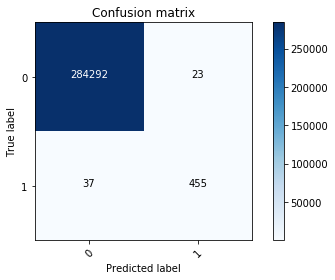

In [18]:
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes = [0,1])

In [20]:
## Undersampling technique
fraud_indices = np.array(data[data.Class == 1].index)
number_records_fraud = len(fraud_indices)
print(number_records_fraud)

492


In [21]:
normal_indices = data[data.Class == 0].index

In [22]:
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)
print(len(random_normal_indices))

492


In [23]:
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
print(len(under_sample_indices))

984


In [24]:
under_sample_data = data.iloc[under_sample_indices,:]

In [25]:
X_undersample = under_sample_data.iloc[:,under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:,under_sample_data.columns == 'Class']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size = 0.3)

In [30]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
model = Sequential([
                    Dense(units = 16, input_dim = 29,activation = 'relu'),
                    Dense(units = 24, activation = 'relu'),
                    Dropout(0.5),
                    Dense(20,activation = 'relu'),
                    Dense(24,activation = 'relu'),
                    Dense(1,activation = 'sigmoid'),
                    ])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,917
Trainable params: 1,917
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 15, epochs = 5) #Training will be much faster now because we are using smaller sample

Epoch 1/5
688/688 [==============================] - 1s 759us/step - loss: 0.5441 - acc: 0.6497
Epoch 2/5
688/688 [==============================] - 0s 70us/step - loss: 0.4097 - acc: 0.8314
Epoch 3/5
688/688 [==============================] - 0s 67us/step - loss: 0.3030 - acc: 0.9055
Epoch 4/5
688/688 [==============================] - 0s 67us/step - loss: 0.2749 - acc: 0.9012
Epoch 5/5
688/688 [==============================] - 0s 67us/step - loss: 0.2197 - acc: 0.9201


Confusion matrix, without normalization
[[137   6]
 [ 12 141]]


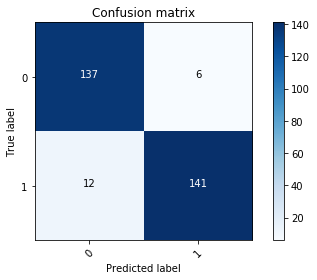

In [36]:
y_pred = model.predict(X_test)
y_expected = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes = [0,1])
plt.show()

Confusion matrix, without normalization
[[276448   7867]
 [    51    441]]


<function matplotlib.pyplot.show(*args, **kw)>

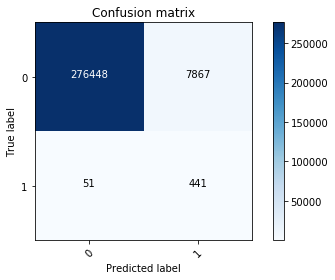

In [38]:
y_pred = model.predict(X)
y_expected = pd.DataFrame(y)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes = [0,1])
plt.show

We will use some oversampling technique such as Smote

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
X_resample, y_resample = SMOTE().fit_sample(X,y.values.ravel())

In [43]:
y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size = 0.3)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 15, epochs = 5) #Training will be much faster now because we are using smaller sample

Epoch 1/5
398041/398041 [==============================] - 26s 66us/step - loss: 0.0386 - acc: 0.9863
Epoch 2/5
398041/398041 [==============================] - 27s 67us/step - loss: 0.0183 - acc: 0.9948
Epoch 3/5
398041/398041 [==============================] - 27s 68us/step - loss: 0.0142 - acc: 0.9960
Epoch 4/5
398041/398041 [==============================] - 26s 66us/step - loss: 0.0126 - acc: 0.9966
Epoch 5/5
398041/398041 [==============================] - 27s 68us/step - loss: 0.0108 - acc: 0.9972


Confusion matrix, without normalization
[[84797   428]
 [    0 85364]]


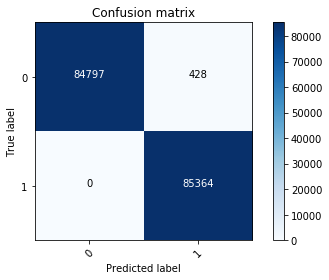

In [44]:
y_pred = model.predict(X_test)
y_expected = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes = [0,1])
plt.show()

Confusion matrix, without normalization
[[283006   1309]
 [     0    492]]


<function matplotlib.pyplot.show(*args, **kw)>

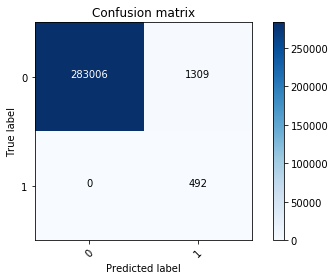

In [45]:
y_pred = model.predict(X)
y_expected = pd.DataFrame(y)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes = [0,1])
plt.show

We detect Zero false positve, but we do not want to disturn the regular user